<h1>Introduction</h1>

For this project, I analyzed a dataset containing 100230 building damage reports from areas effected by the California wildfires. I then trained a Random Forest model to predict the damage a given building has sustained based on information that would be available **before** a wildfire started. The model achieved 92% accuracy! If you find this notebook interesting, an upvote would be much appreciated! 

<h1>Import Libraries and Dataset</h1>

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import warnings

warnings.filterwarnings('ignore') # ignore the annoying warnings kaggle gives

In [2]:
# Load data
data = '/kaggle/input/the-california-wildfire-data/b8aeb030-140d-43d2-aa29-1a80862e3d62.csv'
df = pd.read_csv(data, low_memory=False)

<h1>Dataset Exploration</h1>

Before beginning any data analysis or modelling, I did some basic dataset exploration:

In [3]:
# View dimensions of dataset
df.shape

(100230, 47)

Our dataset has 100230 rows and 47 columns.

In [4]:
# View first five columns of dataset
df.head()

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,...,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,1,No Damage,8376.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,2,Affected (1-9%),8402.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,3,No Damage,8430.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,4,No Damage,3838.0,Putah Creek,Road,NaN,Winters,CA,NaN,...,Quail,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,5,No Damage,3830.0,Putah Creek,Road,NaN,Winters,CA,NaN,...,Quail,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06


In [5]:
# View summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 47 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   _id                                                           100230 non-null  int64  
 1   OBJECTID                                                      100230 non-null  int64  
 2   * Damage                                                      100230 non-null  object 
 3   * Street Number                                               95810 non-null   float64
 4   * Street Name                                                 94744 non-null   object 
 5   * Street Type (e.g. road, drive, lane, etc.)                  87033 non-null   object 
 6   Street Suffix (e.g. apt. 23, blding C)                        44148 non-null   object 
 7   * City                                                  

Several columns contain many null values, which we will have to address before model training. Additionally, many columns contain non-numeric data, which will need to be encoded.

<h1>Data Analysis</h1>

I have a few questions about the data:
- What does the correlation between numerical values look like?
- How do different factors influence the value of a property?
- How does damage differ by city?
- How does damage differ by defensive actions taken?
- What does the geographical distribution of damage look like?


<h3>What does the correlation between numerical values look like?</h3>

Text(0.5, 1.0, 'Numerical columns correlation heatmap')

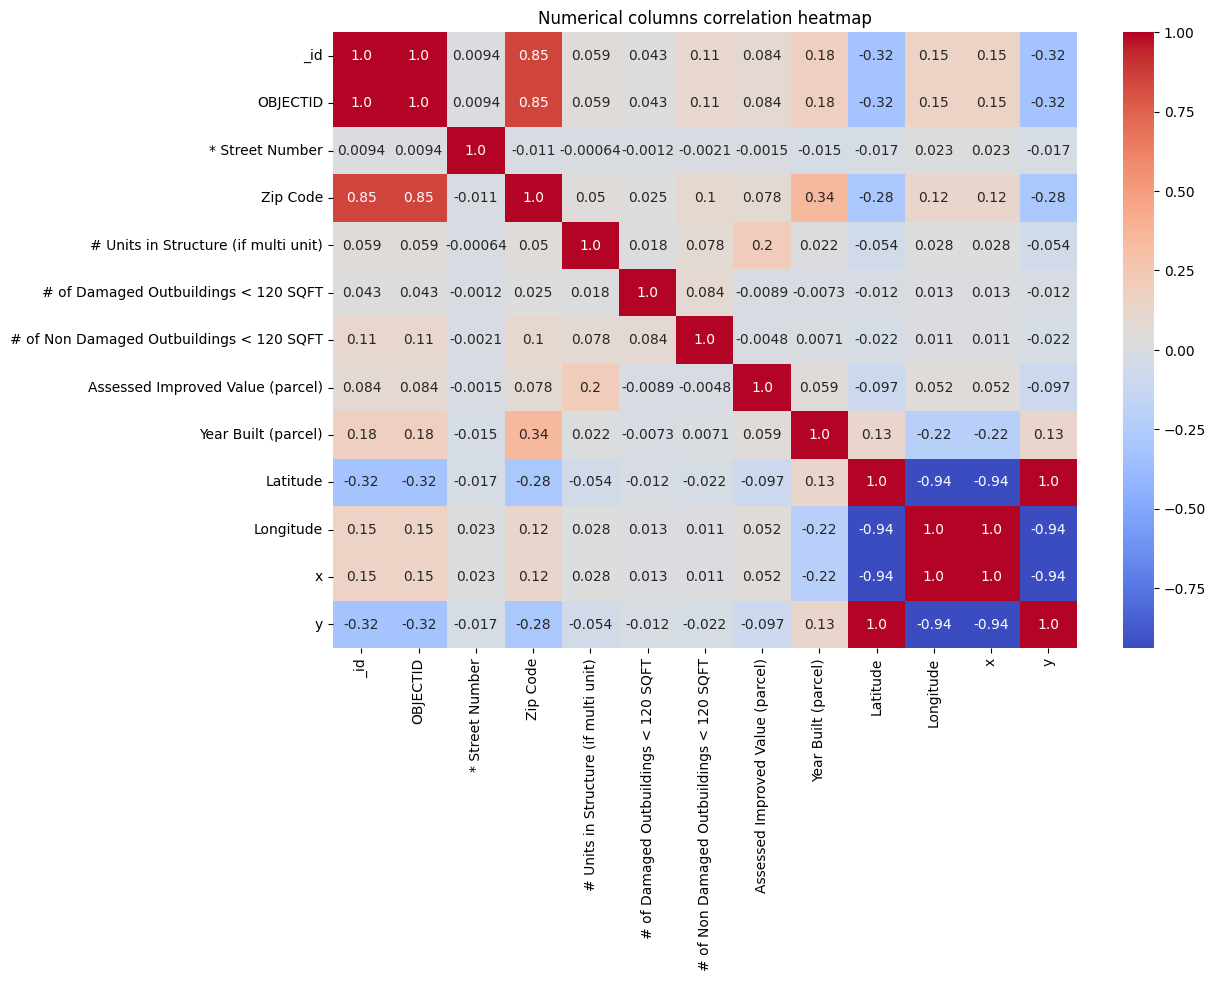

In [6]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

# Drop null values
numeric_cols = numeric_cols.dropna()

# Create corallation matrix
corr_matrix = numeric_cols.corr()

# Visualize with a sns heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap = 'coolwarm', fmt = '0.2')
plt.title('Numerical columns correlation heatmap')

As expected, unique identifiers have a perfect or very high correlation. A few other interesting relationships stand out:
- There is a STRONG negative correlation between longitude and latitude!
- There is a positive correlation between the number of units in a structure and the value of that property
- There is a correlation between zip code and year built
- There is a correlation between year built and longitude and latitude
- There is a negative correlation between year built and longitude and a positive one between year built and latitude
- There is a correlation between ID of the damage report and longitude, latitude and year built

The strong negative correlation between longitude and latitude is explained by the shape of California:

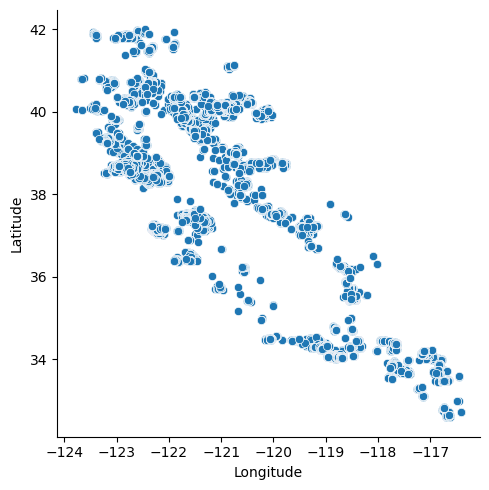

In [7]:
# Plot longitude v latitude
sns.relplot(data = df, x = 'Longitude', y = 'Latitude')

California is approximately a line with a negative slope!

<h3>How do different factors influence the value of a property?</h3>

Many of the correlations found in the correlation matrix were related to the value of the property. Let's represent that data is a nicer way.

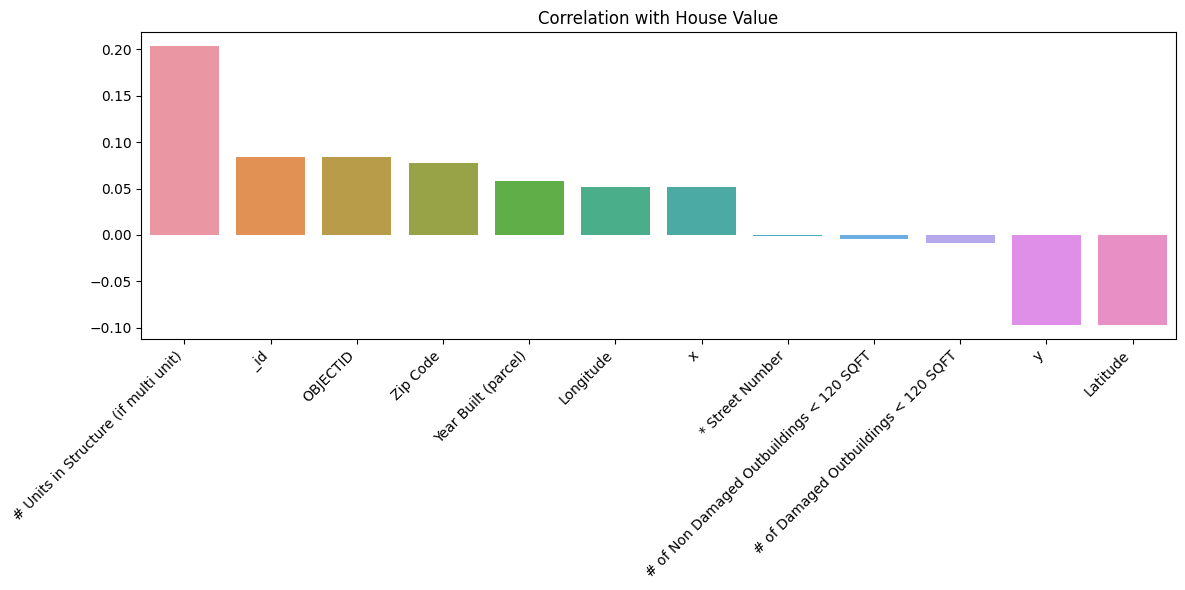

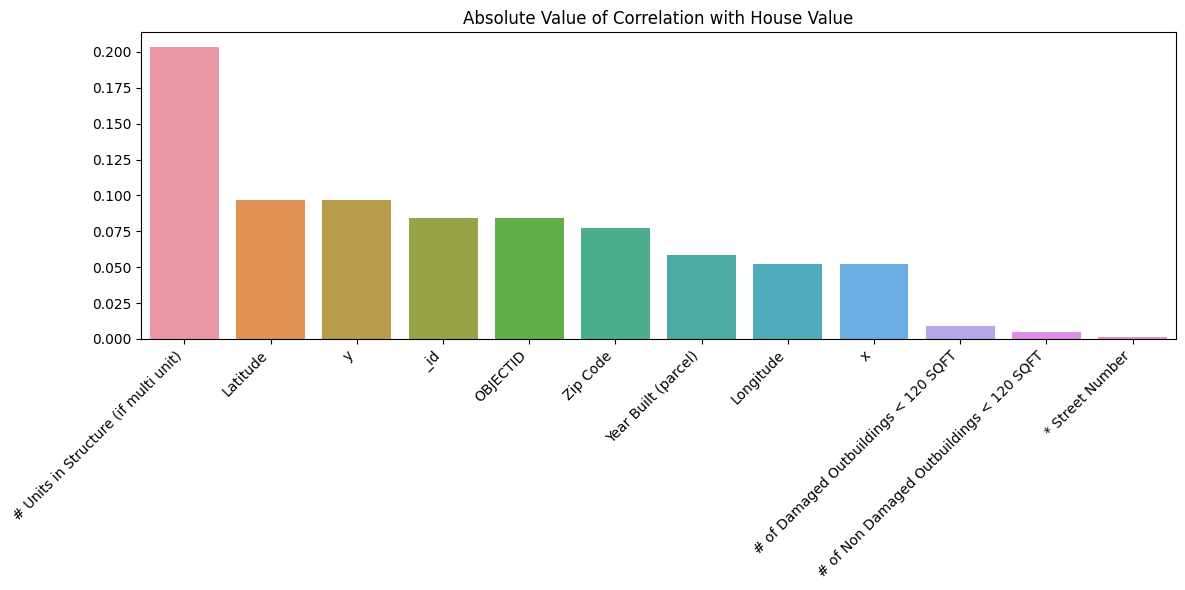

In [8]:
# Remove the correlation with itself (which is always 1)
column_correlations = corr_matrix['Assessed Improved Value (parcel)'].drop('Assessed Improved Value (parcel)')

# Create figure
# Sort correlations in descending order
column_correlations = column_correlations.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=column_correlations.index, y=column_correlations.values)
plt.title(f'Correlation with House Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Create figure with absolute correlation values
plt.figure(figsize=(12, 6))
column_correlations = column_correlations.abs().sort_values(ascending=False)
sns.barplot(x=column_correlations.index, y=column_correlations.values)
plt.title(f'Absolute Value of Correlation with House Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

As we found in our correlation matrix analysis, the value of a property is positively correlated to:
- The number of units in the structure (apartment buildings are worth more than houses)
- The year the building was constructed (newer buildings are worth more)
- Longitude (Eastern buildings are worth more)
- ID (no idea why, probably due to ID's correlation with other factors)
- Zip code (no idea why, probably to Zip code's correlation with other factors)

And negatively correlated to:
- Latitude (Northern buildings are worth less, southern buildings are worth more)

<h3>How does damage differ by city?</h3>

Let's start by plotting the distribution of damage types:

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'No Damage'),
  Text(1, 0, 'Affected (1-9%)'),
  Text(2, 0, 'Minor (10-25%)'),
  Text(3, 0, 'Destroyed (>50%)'),
  Text(4, 0, 'Major (26-50%)'),
  Text(5, 0, 'Inaccessible')])

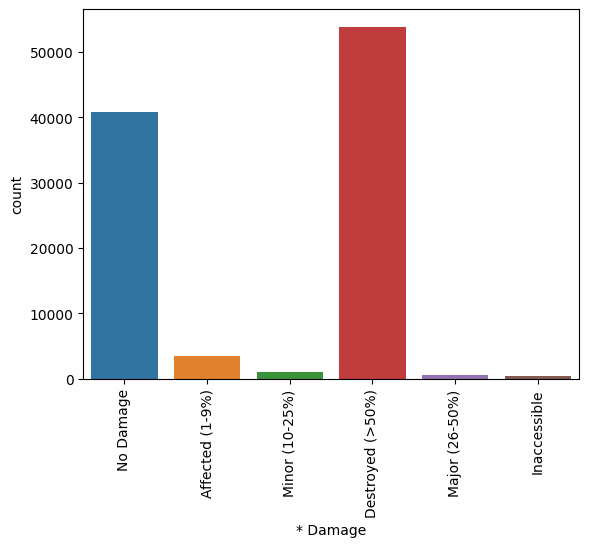

In [9]:
sns.countplot(data = df, x = '* Damage')
plt.xticks(rotation = 90)

It appears that there are very few buildings which suffered minor or major damage. We will bin this data into three categories: No Damage, Affected (which will include the current categories of affected, minor and major damage), and Destroyed.

In [10]:
df = df[df['* Damage'] != 'Inaccessible']
df['* Damage'] = df['* Damage'].replace(['Minor (10-25%)', 'Major (26-50%)'], 'Affected')
df['* Damage'] = df['* Damage'].replace(['Affected (1-9%)'], 'Affected')
df['* Damage'] = df['* Damage'].replace(['Destroyed (>50%)'], 'Destroyed')

(array([0, 1, 2]),
 [Text(0, 0, 'No Damage'), Text(1, 0, 'Affected'), Text(2, 0, 'Destroyed')])

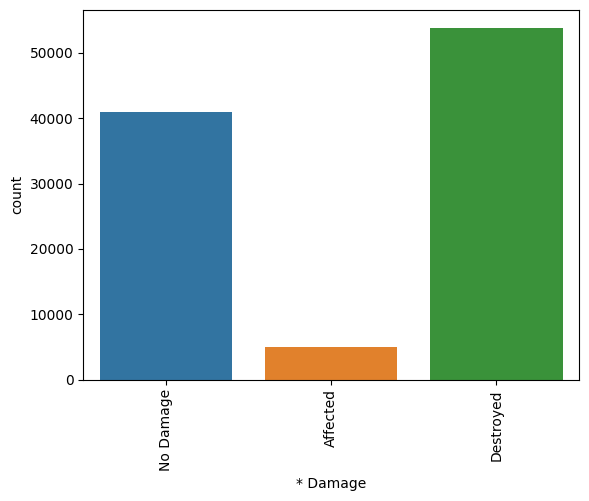

In [11]:
sns.countplot(data = df, x = '* Damage')
plt.xticks(rotation = 90)

Much better. This new categorization will serve us well both in our data analysis and in our upcoming model training! I did not simply bin the data into two categories (Undamaged vs Damaged) because of the imaginary use case of the model: predicting for an individual the damage their home will suffer. I feel that being told your home will be Destroyed, Affected or Undamaged is more motivating and actionable than simply being told that your home will either be Damaged or Undamaged, without any indication of the extent of the harm. 

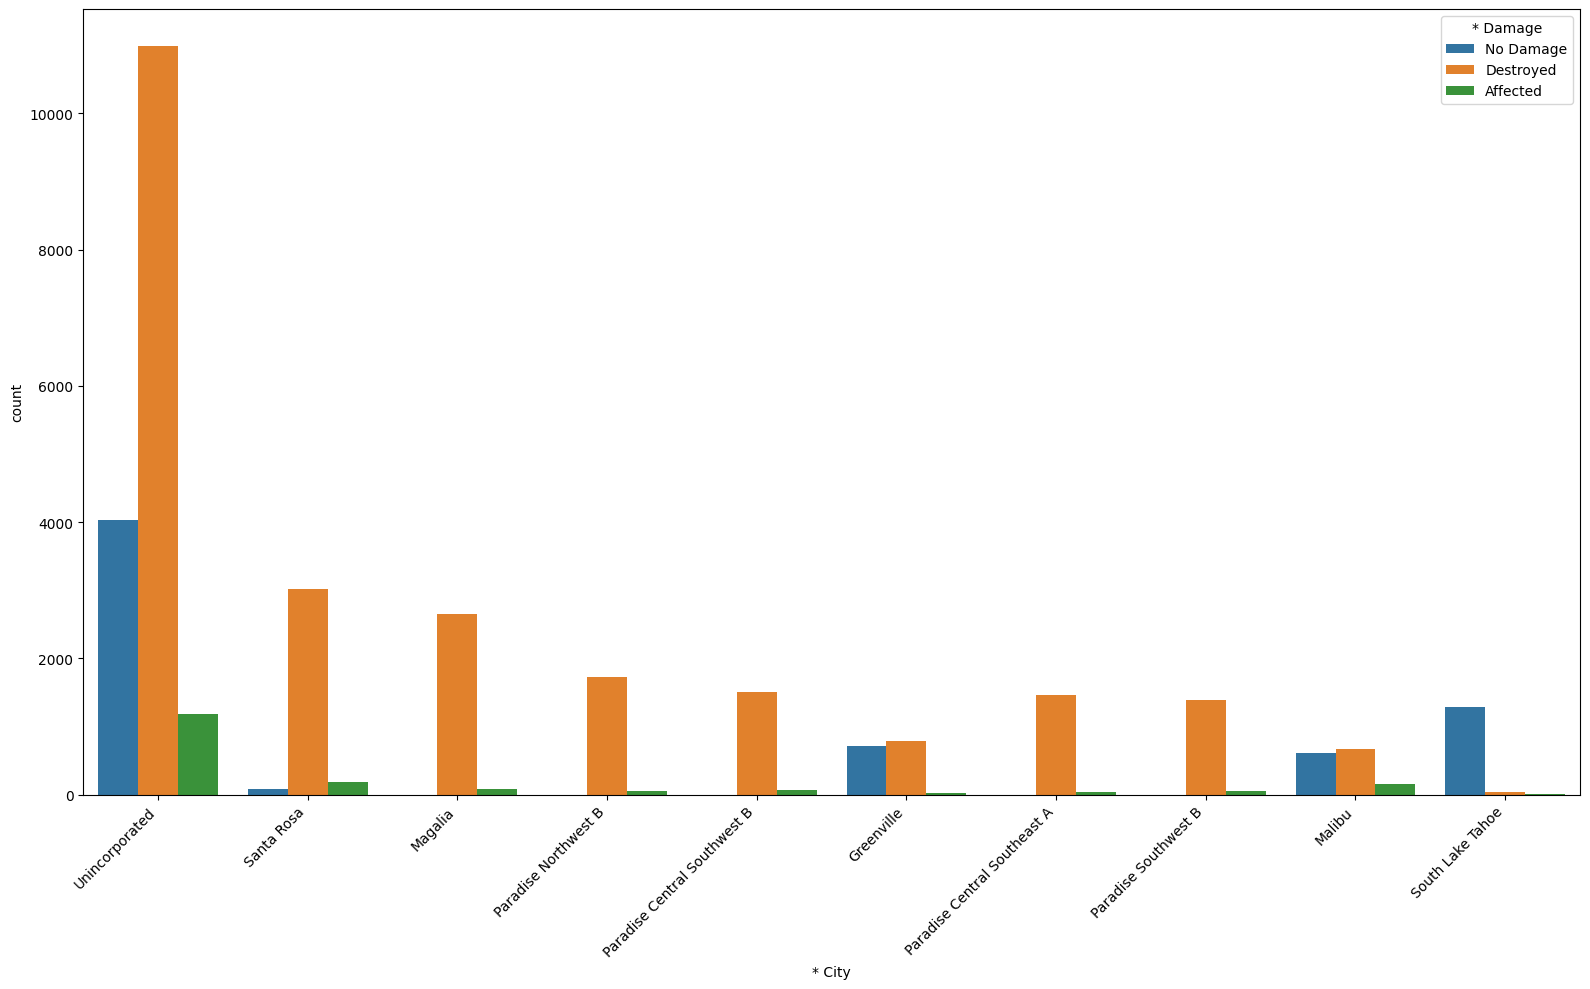

In [12]:
# Get top 10 cities by frequency and sort from most to least
top_cities = df['* City'].value_counts().head(10)

# Create countplot with cities ordered from most to least
plt.figure(figsize=(16, 10))
sns.countplot(data=df[df['* City'].isin(top_cities.index)], 
             x='* City', 
             hue='* Damage', 
             order=top_cities.index)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

This graph shows that out of every city, there are the most buildings which are 'Unincorporated'. The interesting insights come in comparing cities:
Buildings in Magalia were almost always destroyed, whereas buildings in Grenville had a 50/50 shot of being destroyed or unaffected, and buildings in South Lake Tahoe were almost always totally OK. 


<h3>How does damage differ by defensive actions taken?</h3>

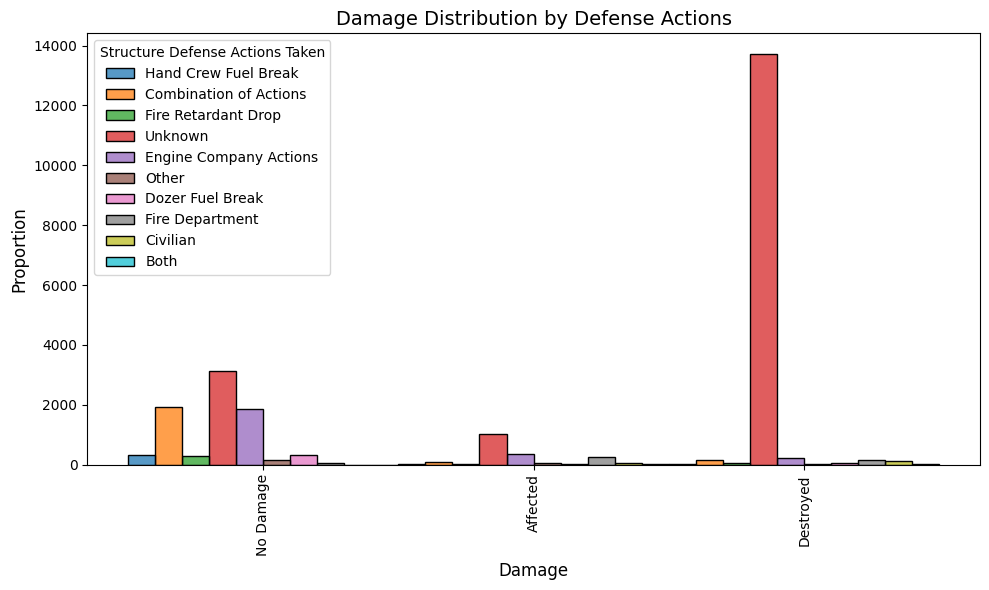

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x ='* Damage', hue ="Structure Defense Actions Taken", multiple="dodge")
plt.title('Damage Distribution by Defense Actions', fontsize=14)
plt.xlabel('Damage', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

From this graph, it is clear that undamaged and affected buildings took a variety of actions, whereas Destroyed buildings overwhelmingly took 'Unknown' (no?) action.

<h3>What does the geographical distribution of damage look like?</h3>

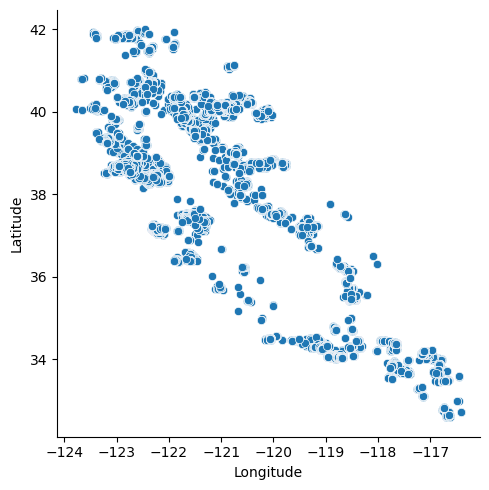

In [14]:
# Plot longitude v latitude
sns.relplot(data = df, x = 'Longitude', y = 'Latitude')

Although this graph reveals the linear nature of California beautifully, and shows the distribution of buildings **surveyed**, it does not give helpful insight into where in the state more houses were **destroyed**. What we really want is a map that will tell us where the fires were better and where they were worse.

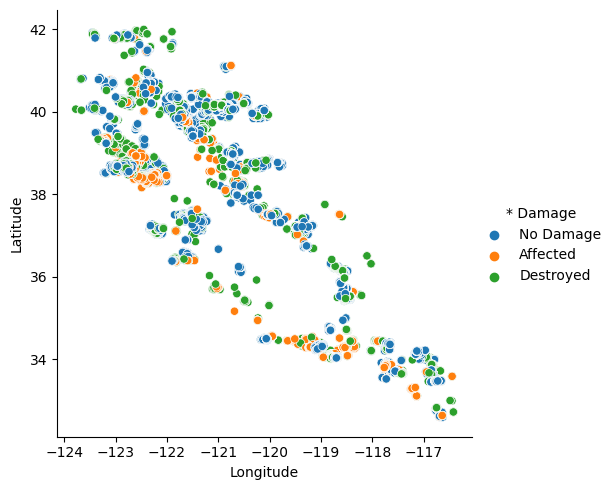

In [15]:
# Plot longitude v latitude, hue = Damage
sns.relplot(data = df, x = 'Longitude', y = 'Latitude', hue = '* Damage')

This is useful, but in some regions with many buildings still does not provide what we want. The ideal graph here would be a heatmap where each zone's colour corresponds to the ration of the destroyed buildings in the area.

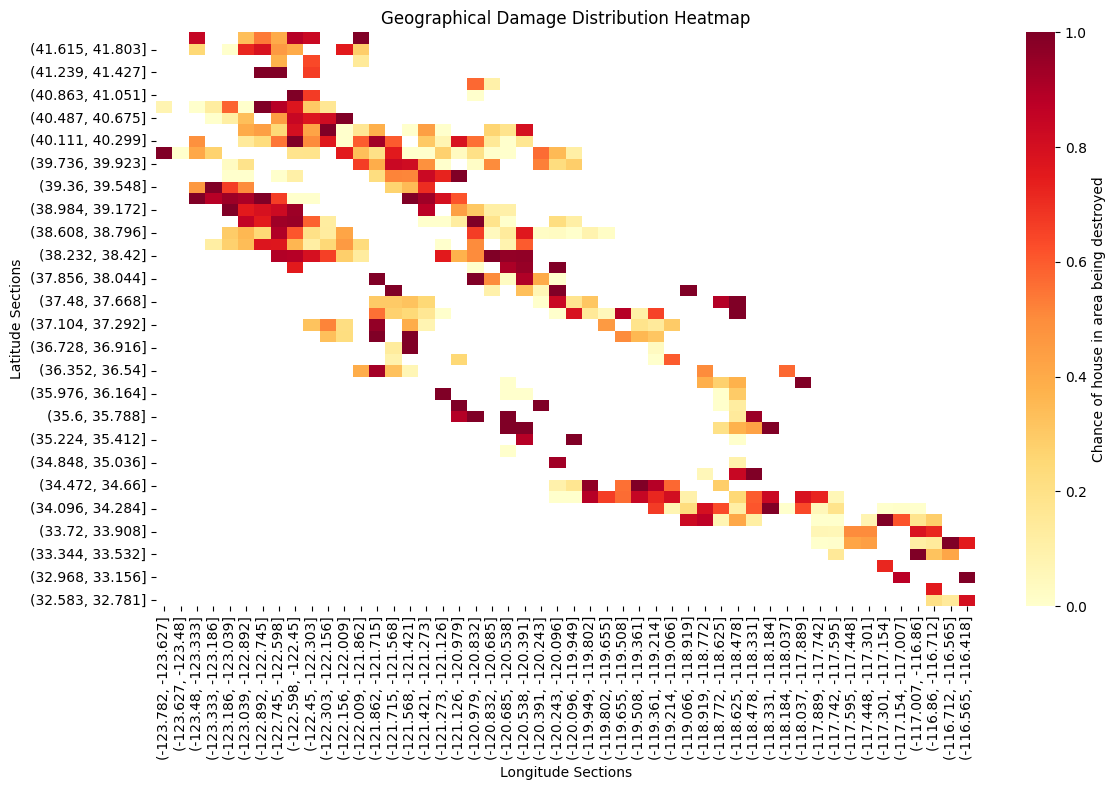

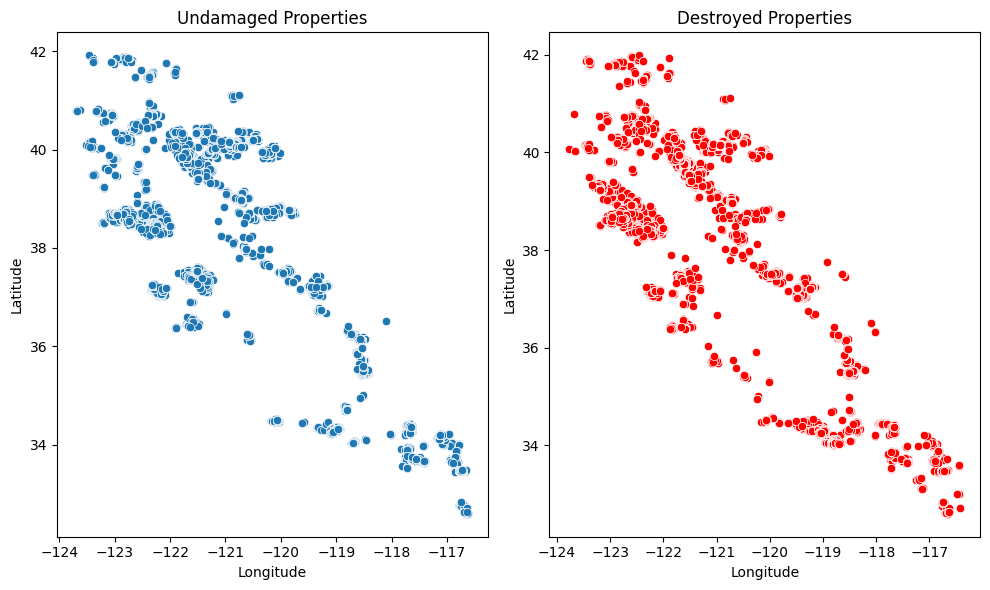

In [16]:
def analyze_damage_distribution(df, num_sections=50):
    """
    Analyze damage distribution across geographical sections
    
    Parameters:
    - df: DataFrame containing damage and location data
    - num_sections: Number of sections to divide longitude and latitude into
    
    Returns:
    - DataFrame with damage ratios for each geographical section
    """
    # Create longitude and latitude bins
    df['long_bin'] = pd.cut(df['Longitude'], bins=num_sections)
    df['lat_bin'] = pd.cut(df['Latitude'], bins=num_sections)
    
    # Group by geographical sections and calculate damage ratio
    damage_distribution = df.groupby(['long_bin', 'lat_bin']).apply(
        lambda x: pd.Series({
            'damage_ratio': len(x[x['* Damage'] == 'Destroyed']) / len(x)
        })
    ).reset_index()
    
    return damage_distribution

def visualize_damage_heatmap(damage_distribution):
    """
    Create a heatmap of damage ratios
    
    Parameters:
    - damage_distribution: DataFrame with damage distribution data
    """
    plt.figure(figsize=(12, 8))
    pivot_data = damage_distribution.pivot(
        index='lat_bin', 
        columns='long_bin', 
        values='damage_ratio'
    )
    
    sns.heatmap(
        pivot_data, 
        cmap='YlOrRd', 
        annot=False, 
        fmt='.2f', 
        cbar_kws={'label': 'Chance of house in area being destroyed'}
    )
    plt.title('Geographical Damage Distribution Heatmap')
    plt.xlabel('Longitude Sections')
    plt.ylabel('Latitude Sections')
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

def plot_damage_distributions(df):
    """
    Plot geographical distributions of undamaged and damaged properties
    
    Parameters:
    - df: DataFrame containing damage and location data
    """
    # Undamaged properties
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        data=df[df['* Damage'] == 'No Damage'], 
        x='Longitude', 
        y='Latitude'
    )
    plt.title('Undamaged Properties')
    
    # Damaged properties
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        data=df[df['* Damage'] == 'Destroyed'], 
        x='Longitude', 
        y='Latitude', 
        color='red'
    )
    plt.title('Destroyed Properties')
    plt.tight_layout()
    plt.show()

damage_dist = analyze_damage_distribution(df)
visualize_damage_heatmap(damage_dist)
plot_damage_distributions(df)

<h1>Model Training!</h1>

I will now train a random forest model to predict the damage a house will suffer based only on information that would be available before a fire started. 

<h1>1. Data cleaning and parameter selection</h1>

All columns which contain repeated information (eg. many redundant unique identifiers), have too few entries or contain info that would not be available before a fire began will be dropped.

In [17]:
df = df.drop(['OBJECTID',
              '_id',
              'Street Suffix (e.g. apt. 23, blding C)',
              'State',
              'Zip Code',
              'Community',
              'Battalion',
              'Incident Number (e.g. CAAEU 123456)',
              'Hazard Type',
              'Fire Name (Secondary)',
              'Distance - Residence to Utility/Misc Structure &gt; 120 SQFT',
              'APN (parcel)',
              'Distance - Propane Tank to Structure',
              'GLOBALID',
              'Site Address (parcel)',
              '# Units in Structure (if multi unit)',
              '* Structure Type',
              '* Fence Attached to Structure',
              'x',
              'y',
              '* City',
              '* Incident Name',
              'Incident Start Date',
              'If Affected 1-9% - Where did fire start?',
              'If Affected 1-9% - What started fire?',
              '# of Damaged Outbuildings < 120 SQFT',
              '# of Non Damaged Outbuildings < 120 SQFT'
             ], axis=1)

With that done, we recall that the structural defence actions column had many null values. We assume that a null value means no action was taken, and fill it with "None".

In [18]:
# Make Structure defense NaNs into 'None'
df['Structure Defense Actions Taken'] = df['Structure Defense Actions Taken'].fillna('None')

# Drop all rows with missing values
df = df.dropna()

Let's take a look at our cleaned data. This will be what our model is trained on.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58971 entries, 0 to 100229
Data columns (total 22 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   * Damage                                      58971 non-null  object  
 1   * Street Number                               58971 non-null  float64 
 2   * Street Name                                 58971 non-null  object  
 3   * Street Type (e.g. road, drive, lane, etc.)  58971 non-null  object  
 4   * CAL FIRE Unit                               58971 non-null  object  
 5   County                                        58971 non-null  object  
 6   Structure Defense Actions Taken               58971 non-null  object  
 7   Structure Category                            58971 non-null  object  
 8   * Roof Construction                           58971 non-null  object  
 9   * Eaves                                       58971 no

In [20]:
df.head()

,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* CAL FIRE Unit,County,Structure Defense Actions Taken,Structure Category,* Roof Construction,* Eaves,...,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude,long_bin,lat_bin
0,No Damage,8376.0,Quail Canyon,Road,LNU,Solano,None,Single Residence,Asphalt,Unenclosed,...,Single Pane,Wood,Wood,No Patio Cover/Carport,510000.0,1997.0,38.474960,-122.044465,"(-122.156, -122.009]","(38.42, 38.608]"
1,Affected,8402.0,Quail Canyon,Road,LNU,Solano,Hand Crew Fuel Break,Single Residence,Asphalt,Unenclosed,...,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,573052.0,1980.0,38.477442,-122.043252,"(-122.156, -122.009]","(38.42, 38.608]"
2,No Damage,8430.0,Quail Canyon,Road,LNU,Solano,None,Single Residence,Asphalt,Enclosed,...,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,350151.0,2004.0,38.479358,-122.044585,"(-122.156, -122.009]","(38.42, 38.608]"
3,No Damage,3838.0,Putah Creek,Road,LNU,Solano,None,Single Residence,Asphalt,Unenclosed,...,Single Pane,No Deck/Porch,No Deck/Porch,Combustible,134880.0,1981.0,38.487313,-122.015115,"(-122.156, -122.009]","(38.42, 38.608]"
4,No Damage,3830.0,Putah Creek,Road,LNU,Solano,None,Single Residence,Tile,Enclosed,...,Multi Pane,Wood,Wood,Combustible,346648.0,1980.0,38.485636,-122.016122,"(-122.156, -122.009]","(38.42, 38.608]"


We will be training our model on 60,000 cases, each described by 22 parameters. No null values are left in our data.

<h1>2. Divide into X and y, and train test split, encode and scale</h1>

The last two things we need to do before we can train our model is to convert every piece of data into numbers and split our data into training and testing sets. We encode non-numeric data with sklearn's OneHot encoder and scale numeric data with StandardScaler so that it does not have an outsized effect on the model.

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Divide into X and y and encode y (label encoder because ordinal)
le = LabelEncoder()
y = le.fit_transform(df['* Damage'])
X = df.drop(['* Damage'], axis=1)

# Divide X data into numerical and catagorical
numerical_col = X.select_dtypes(include = 'float64').columns.tolist()
catagorical_col = X.select_dtypes(exclude = 'float64').columns.tolist()

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Create preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), catagorical_col)
    ])

# Do preprocessing 
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

<h1>3. Train a random forest model!</h1>

Now it is time to train our model!

In [22]:
# Import Random Forest classifier

from sklearn.ensemble import RandomForestClassifier


# Instantiate the classifier 

rfc = RandomForestClassifier(random_state=42)


# Fit the model

rfc.fit(X_train, y_train)


# Predict the Test set results

y_pred = rfc.predict(X_test)


# Check accuracy score 

from sklearn.metrics import accuracy_score

print('Model accuracy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy: 0.9185


92% Accuracy!

<h1>4. Evaluate the model</h1>

Finally, we evaluate the model to see which characteristics it weighed most highly and take a look at the confusion matrix.

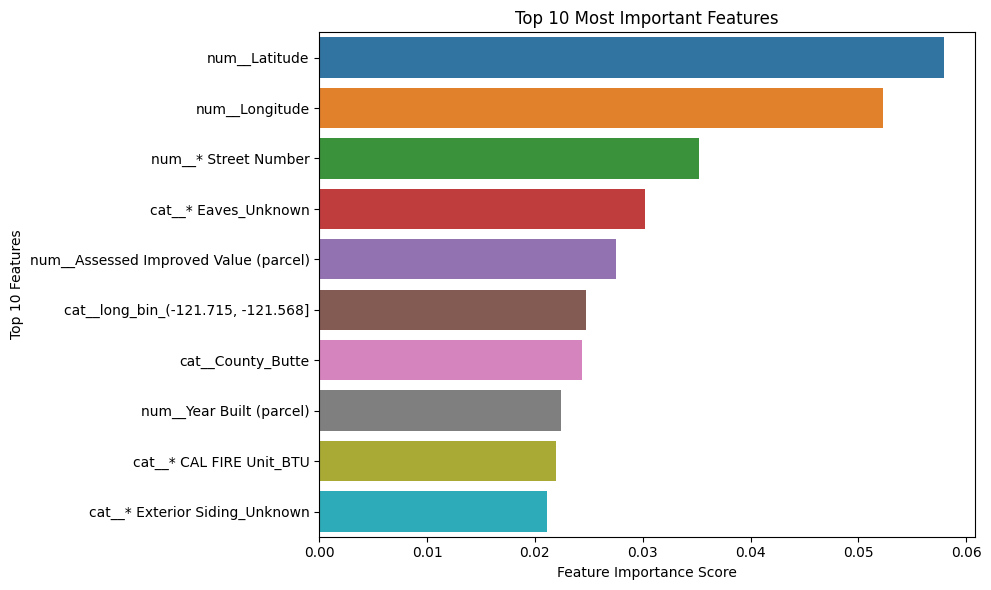

<Figure size 1000x800 with 0 Axes>

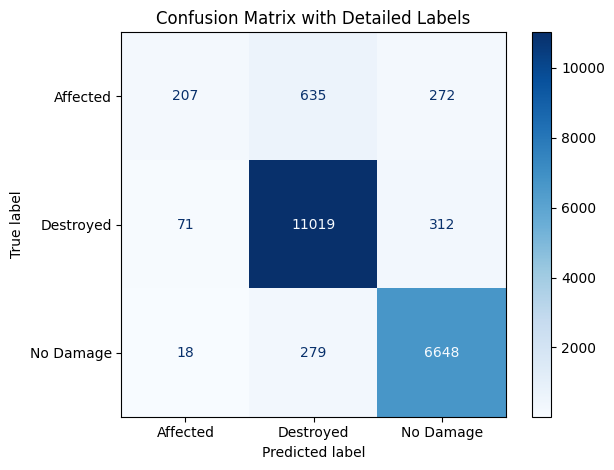

In [23]:
# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Calculate feature scores
feature_scores = pd.Series(rfc.feature_importances_, index=feature_names).sort_values(ascending=False)

# Select top 10 most influential features
top_10_features = feature_scores.head(10)

# Create bar plot for top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Top 10 Features')
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.show()

# Confusion Matrix with labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = le.classes_

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix with Detailed Labels')
plt.tight_layout()
plt.show()